# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

from mlde_analysis.utils import chained_groupby_map
from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map, SUBREGIONS
from mlde_analysis.bootstrap import resample_examples
from mlde_analysis.ccs import compute_changes, plot_changes, plot_tp_fd, plot_hist_per_tp, plot_ccs_fc_figure, ccs_fc_da
from mlde_analysis.distribution import PER_GRIDBOX_QUANTILES, normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias, compute_metrics, DIST_THRESHOLDS
from mlde_analysis.fractional_contribution import compute_fractional_contribution, frac_contrib_change, fc_bins
from mlde_analysis.wet_dry import threshold_exceeded_prop_stats, threshold_exceeded_prop_change, plot_threshold_exceedence_errors, THRESHOLDS
from mlde_analysis.display import VAR_RANGES, pretty_table
from mlde_utils import cp_model_rotated_pole, TIME_PERIODS

cannot find .env file


In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM_GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

In [ ]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"] for var in eval_vars }

PRED_DAS = { var: xr.concat([ ds[f"pred_{var}"] for ds in EVAL_DS.values() ], dim="model") for var in eval_vars }

MODELLABEL2SPEC = { model: {"source": source} | spec for source, models in MODELS.items() for model, spec in models.items() } | {"CPM": {"source": "CPM", "color": "black"}}

In [ ]:
CCS_SEASONS = ["DJF", "JJA"]

In [ ]:
CCS_MODELS = {source: {model: spec for model, spec in mconfigs.items() if spec.get("CCS", False)} for source, mconfigs in MODELS.items() }

CCS_PRED_DAS = {var: PRED_DAS[var].sel(model=list([model for source, models in CCS_MODELS.items() for model in models])) for var in eval_vars }

CCS_DS = xr.combine_by_coords([*list(CPM_DAS.values()), *list(CCS_PRED_DAS.values())])

## Figure: per Time Period per season frequency density

* Frequency Density Histogram of rainfall intensities for each time period

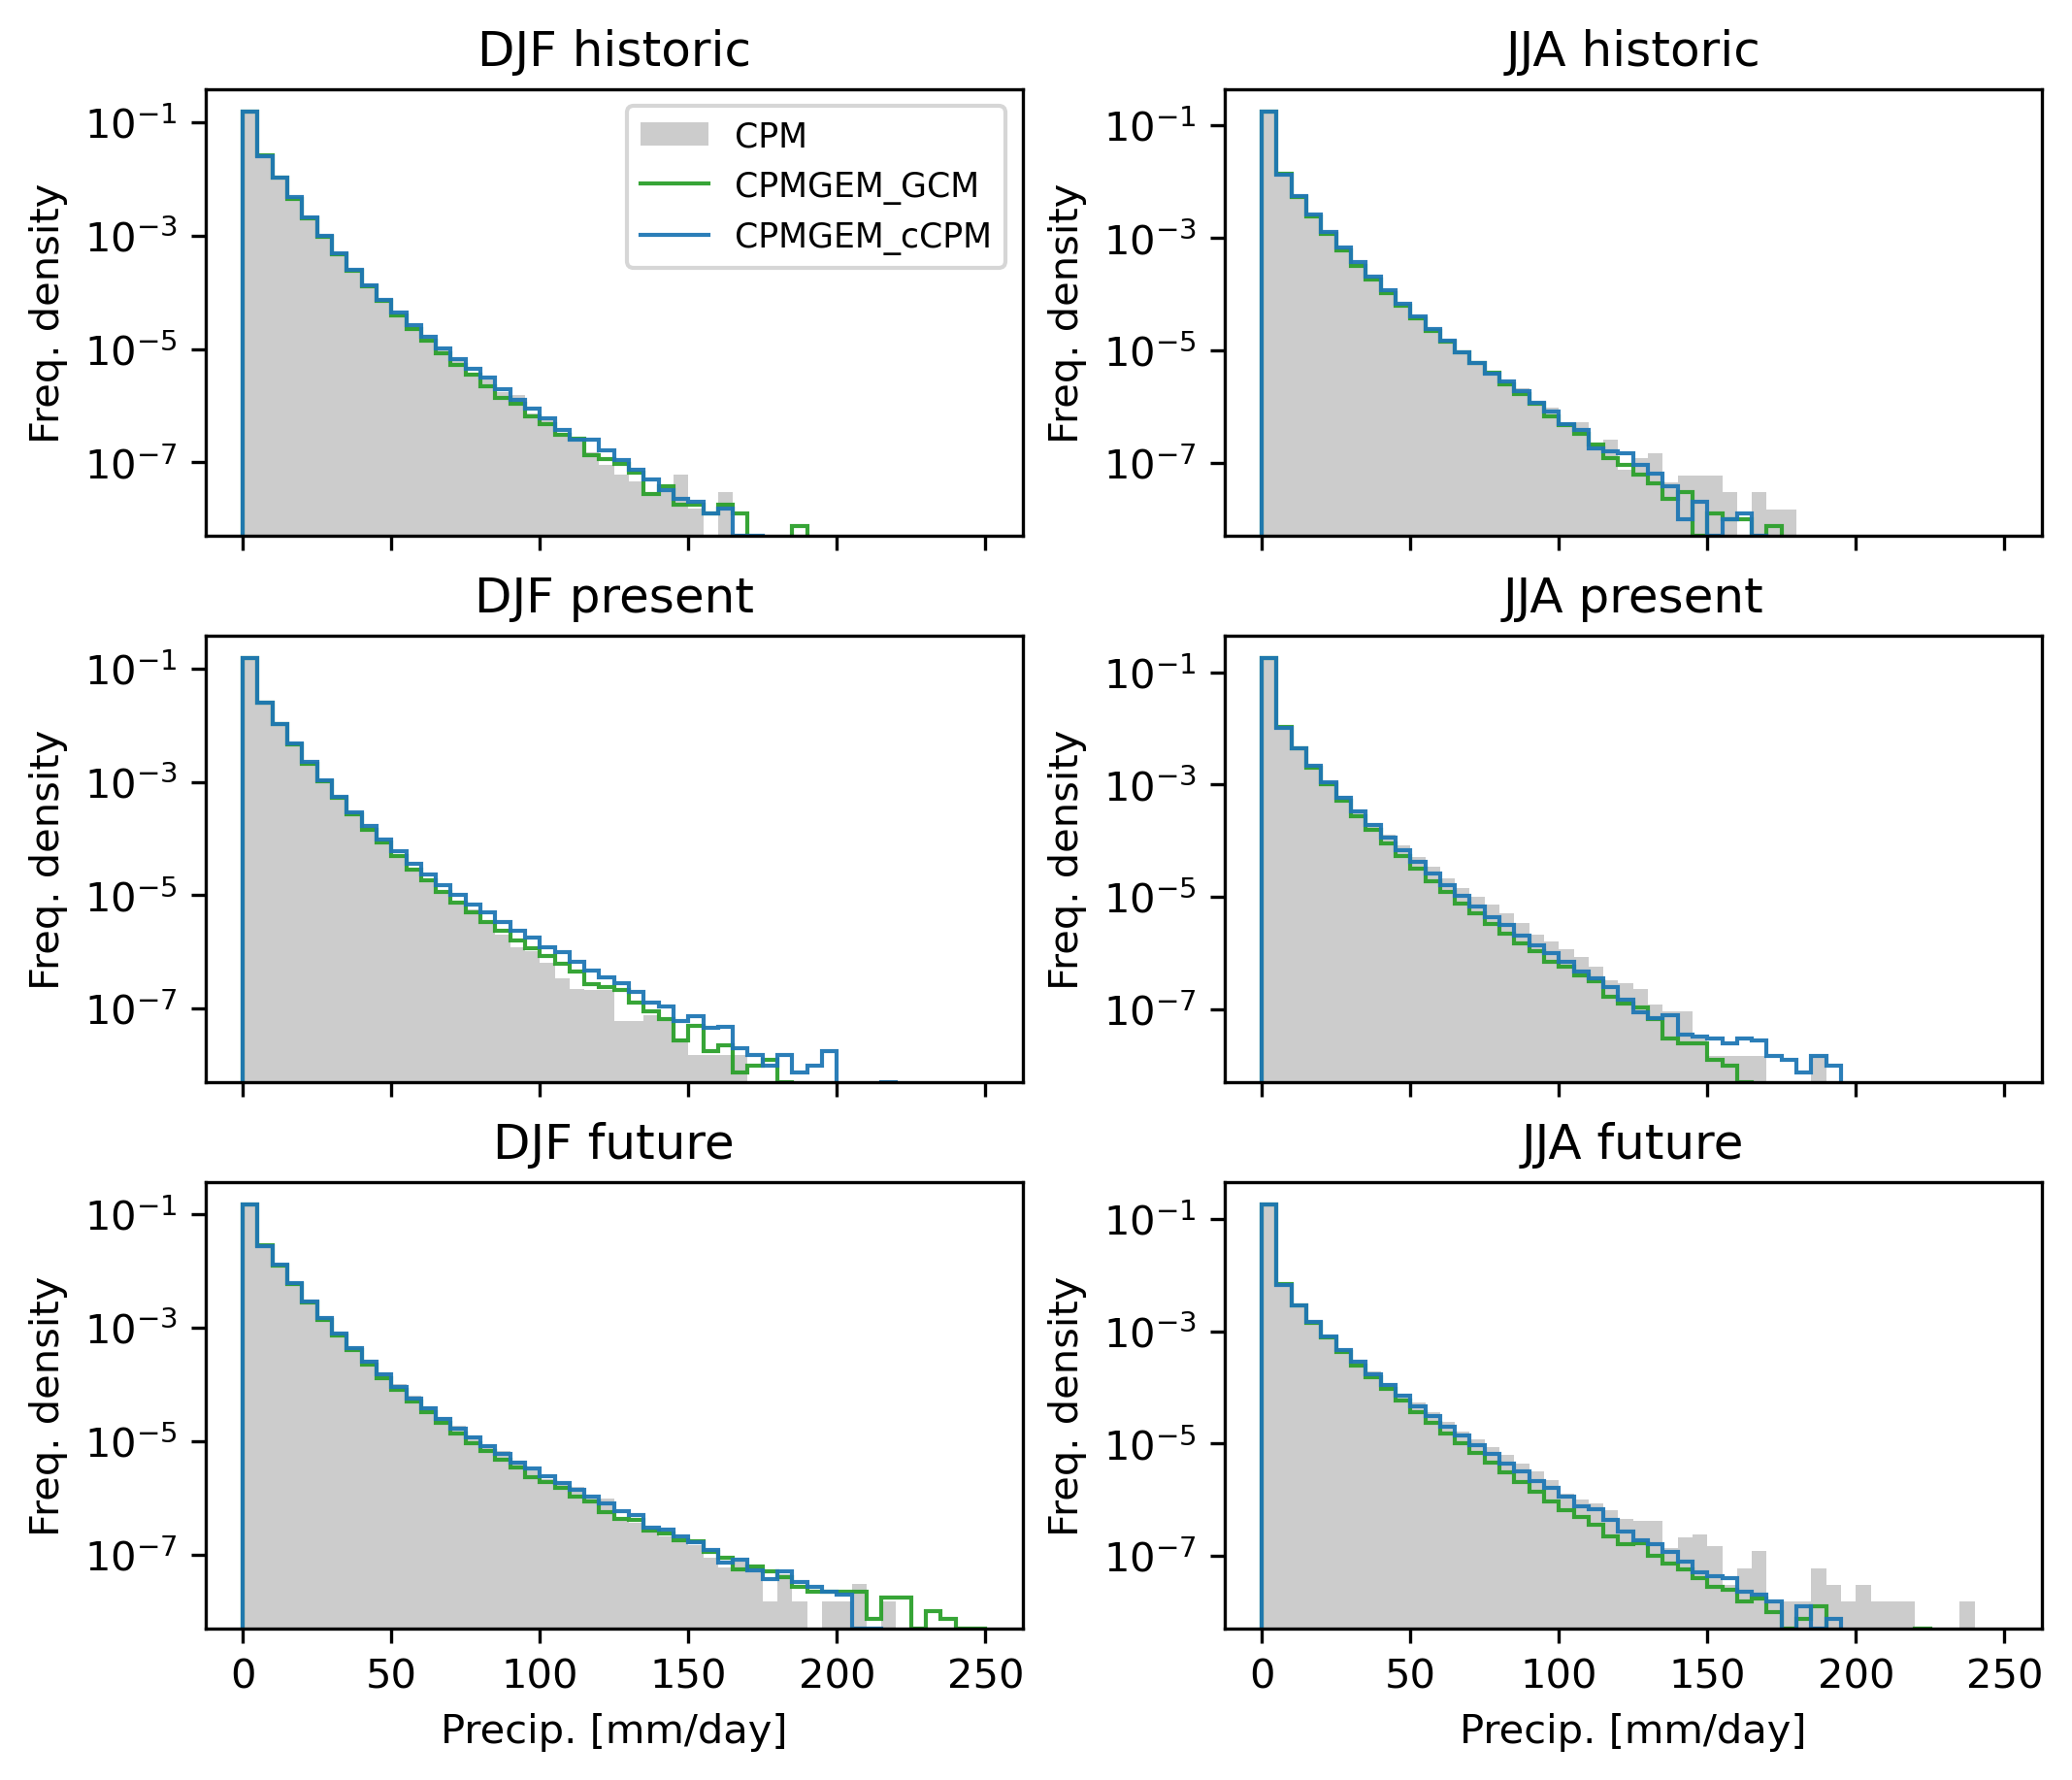

In [ ]:
for var in eval_vars:
    fig = plt.figure(layout='constrained', figsize=(3.5*len(CCS_SEASONS), 2*len(TIME_PERIODS)))
    spec = np.array(list([[f"{season} {tp_key}" for season in CCS_SEASONS] for tp_key in TIME_PERIODS.keys() ]))
    
    axd = fig.subplot_mosaic(spec, sharex=True)
    for season, seasonal_ccs_ds in CCS_DS.groupby("time.season"):
        if season not in CCS_SEASONS:
            continue
        
        for tp_key, tp_ds in seasonal_ccs_ds.groupby("time_period"):
            ax = axd[f"{season} {tp_key}"]
            hist_data = [ dict(data=model_ds[f"pred_{var}"], label=model, color=MODELLABEL2SPEC[model]["color"]) for model, model_ds in tp_ds.groupby("model") ]
            hrange=VAR_RANGES[var]
            plot_freq_density(hist_data, ax=ax, target_da=tp_ds[f"target_{var}"], legend=(tp_key=="historic" and season=="DJF"), linewidth=1, title=f"{season} {tp_key}", hrange=hrange)
    
            ax.xaxis.label.set_visible(tp_key == "future")    
            
    plt.show()

### Per time period per season metrics

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)

    metrics_ds = CCS_DS.groupby("time.season").map(lambda season_ds: season_ds.groupby("time_period").map(lambda tp_ds: compute_metrics(tp_ds[f"pred_{var}"], tp_ds[f"target_{var}"], thresholds=DIST_THRESHOLDS[var])))
        
    pretty_table(metrics_ds, round=4, dim_order=["season", "time_period", "model"], caption="Distribution metrics per season and time period")

### pr

Distribution metrics per season and time period 
 
 
   
   
   
 RMS Mean Bias (mm/day) 
 RMS Std Dev Bias (mm/day) 
 Relative RMS Mean Bias (%) 
 Relative RMS Std Dev Bias (%) 
 J-S distance 
 Emu > 0.1 
 Emu > 0.1 - CPM > 0.1 
 Emu > 25 
 Emu > 25 - CPM > 25 
 Emu > 75 
 Emu > 75 - CPM > 75 
 Emu > 125 
 Emu > 125 - CPM > 125 
 
 
 season 
 time_period 
 model 
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 DJF 
 future 
 CPMGEM_GCM 
 0.2400 
 0.4300 
 5.8200 
 6.6800 
 0.0117 
 0.6948 
 -0.0044 
 0.0154 
 -0.0028 
 0.0002 
 -0.0001 
 0.0000 
 0.0000 
 
 
 CPMGEM_cCPM 
 0.1800 
 0.2700 
 4.8200 
 4.5000 
 0.0069 
 0.6785 
 -0.0207 
 0.0169 
 -0.0013 
 0.0002 
 -0.0000 
 0.0000 
 0.0000 
 
 
 historic 
 CPMGEM_GCM 
 0.1300 
 0.2100 
 3.7900 
 4.0500 
 0.0042 
 0.6798 
 0.0167 
 0.0099 
 0.0001 
 0.0001 
 -0.0000 
 0.0000 
 0.0000 
 
 
 CPMGEM_cCPM 
 0.1200 
 0.1800 
 2.5100 
 3.1800 
 0.0037 
 0.6633 
 0.0002 
 0.0102 
 0.0004 
 0.0001 
 0.0000 
 0.0000 
 0.0000 
 
 
 present 
 CPMGEM_GCM 
 0.1300 
 0.2300 
 3.5300 
 4.1500 
 0.0070 
 0.6693 
 0.0083 
 0.0108 
 -0.0007 
 0.0001 
 0.0000 
 0.0000 
 0.0000 
 
 
 CPMGEM_cCPM 
 0.1200 
 0.2100 
 3.1800 
 3.2700 
 0.0046 
 0.6509 
 -0.0101 
 0.0118 
 0.0002 
 0.0001 
 0.0000 
 0.0000 
 0.0000 
 
 
 JJA 
 future 
 CPMGEM_GCM 
 0.0800 
 0.5200 
 7.6900 
 12.2400 
 0.0075 
 0.2931 
 0.0104 
 0.0054 
 -0.0014 
 0.0001 
 -0.0001 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.0700 
 0.4100 
 6.0800 
 9.5000 
 0.0031 
 0.2836 
 0.0009 
 0.0063 
 -0.0005 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 historic 
 CPMGEM_GCM 
 0.1300 
 0.3500 
 6.2500 
 7.2900 
 0.0072 
 0.4615 
 0.0229 
 0.0067 
 -0.0008 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.0900 
 0.2500 
 4.4200 
 5.5600 
 0.0041 
 0.4401 
 0.0016 
 0.0076 
 0.0001 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 present 
 CPMGEM_GCM 
 0.1600 
 0.5900 
 9.4700 
 12.8400 
 0.0109 
 0.3968 
 0.0111 
 0.0059 
 -0.0019 
 0.0001 
 -0.0001 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.1000 
 0.3700 
 6.2500 
 8.1600 
 0.0054 
 0.3819 
 -0.0038 
 0.0071 
 -0.0008 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 MAM 
 future 
 CPMGEM_GCM 
 0.1800 
 0.2400 
 7.4300 
 5.6100 
 0.0113 
 0.5706 
 0.0259 
 0.0071 
 0.0004 
 0.0000 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.1100 
 0.2100 
 3.5600 
 4.2800 
 0.0045 
 0.5479 
 0.0031 
 0.0074 
 0.0007 
 0.0001 
 0.0000 
 0.0000 
 -0.0000 
 
 
 historic 
 CPMGEM_GCM 
 0.2500 
 0.2800 
 11.1600 
 7.5300 
 0.0203 
 0.6098 
 0.0427 
 0.0053 
 0.0010 
 0.0000 
 0.0000 
 0.0000 
 0.0000 
 
 
 CPMGEM_cCPM 
 0.1300 
 0.2300 
 5.3700 
 5.5300 
 0.0082 
 0.5777 
 0.0107 
 0.0051 
 0.0008 
 0.0000 
 0.0000 
 0.0000 
 0.0000 
 
 
 present 
 CPMGEM_GCM 
 0.1600 
 0.2200 
 7.2800 
 5.4200 
 0.0124 
 0.5869 
 0.0292 
 0.0054 
 -0.0001 
 0.0000 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.0900 
 0.1800 
 3.4800 
 4.0500 
 0.0020 
 0.5610 
 0.0034 
 0.0056 
 0.0002 
 0.0000 
 0.0000 
 0.0000 
 -0.0000 
 
 
 SON 
 future 
 CPMGEM_GCM 
 0.1600 
 0.5100 
 6.1300 
 9.0700 
 0.0075 
 0.4831 
 0.0032 
 0.0130 
 -0.0018 
 0.0002 
 -0.0001 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.2100 
 0.4700 
 8.6400 
 8.2500 
 0.0098 
 0.4588 
 -0.0211 
 0.0132 
 -0.0017 
 0.0002 
 -0.0001 
 0.0000 
 -0.0000 
 
 
 historic 
 CPMGEM_GCM 
 0.1700 
 0.3500 
 5.7000 
 6.1700 
 0.0087 
 0.5796 
 0.0238 
 0.0103 
 -0.0007 
 0.0001 
 -0.0000 
 0.0000 
 0.0000 
 
 
 CPMGEM_cCPM 
 0.1800 
 0.3500 
 6.3900 
 6.4100 
 0.0077 
 0.5525 
 -0.0033 
 0.0099 
 -0.0011 
 0.0001 
 0.0000 
 0.0000 
 0.0000 
 
 
 present 
 CPMGEM_GCM 
 0.1800 
 0.4400 
 6.0000 
 7.3900 
 0.0094 
 0.5331 
 0.0082 
 0.0128 
 -0.0017 
 0.0002 
 -0.0001 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.2100 
 0.4000 
 7.5600 
 6.8100 
 0.0112 
 0.5118 
 -0.0131 
 0.0132 
 -0.0013 
 0.0002 
 -0.0000 
 0.0000 
 0.0000

## Change in mean

### Mean change maps

#### pr

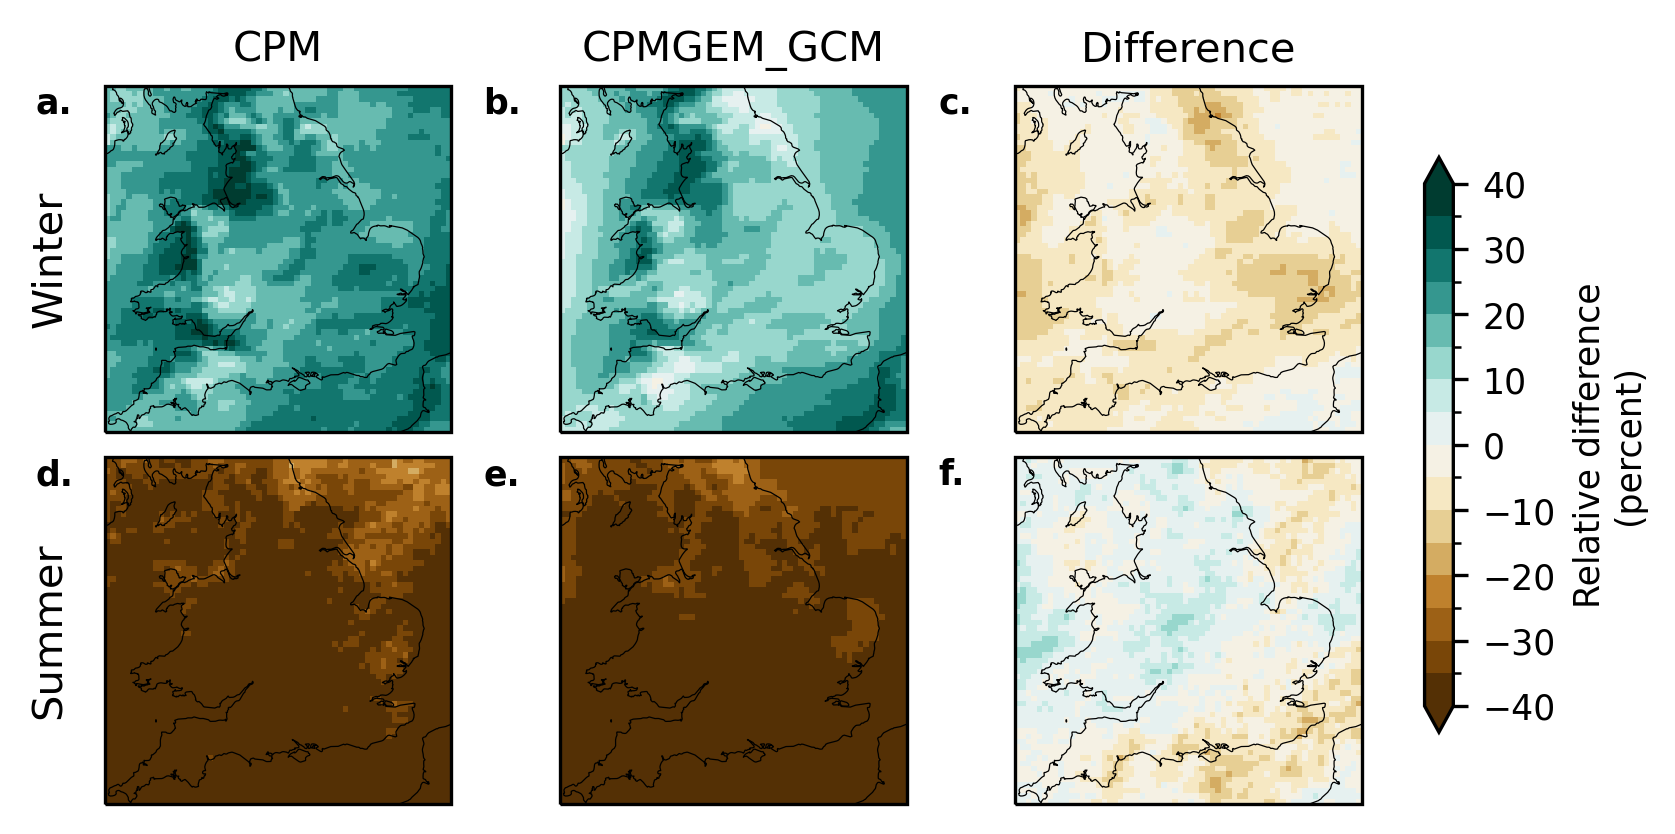

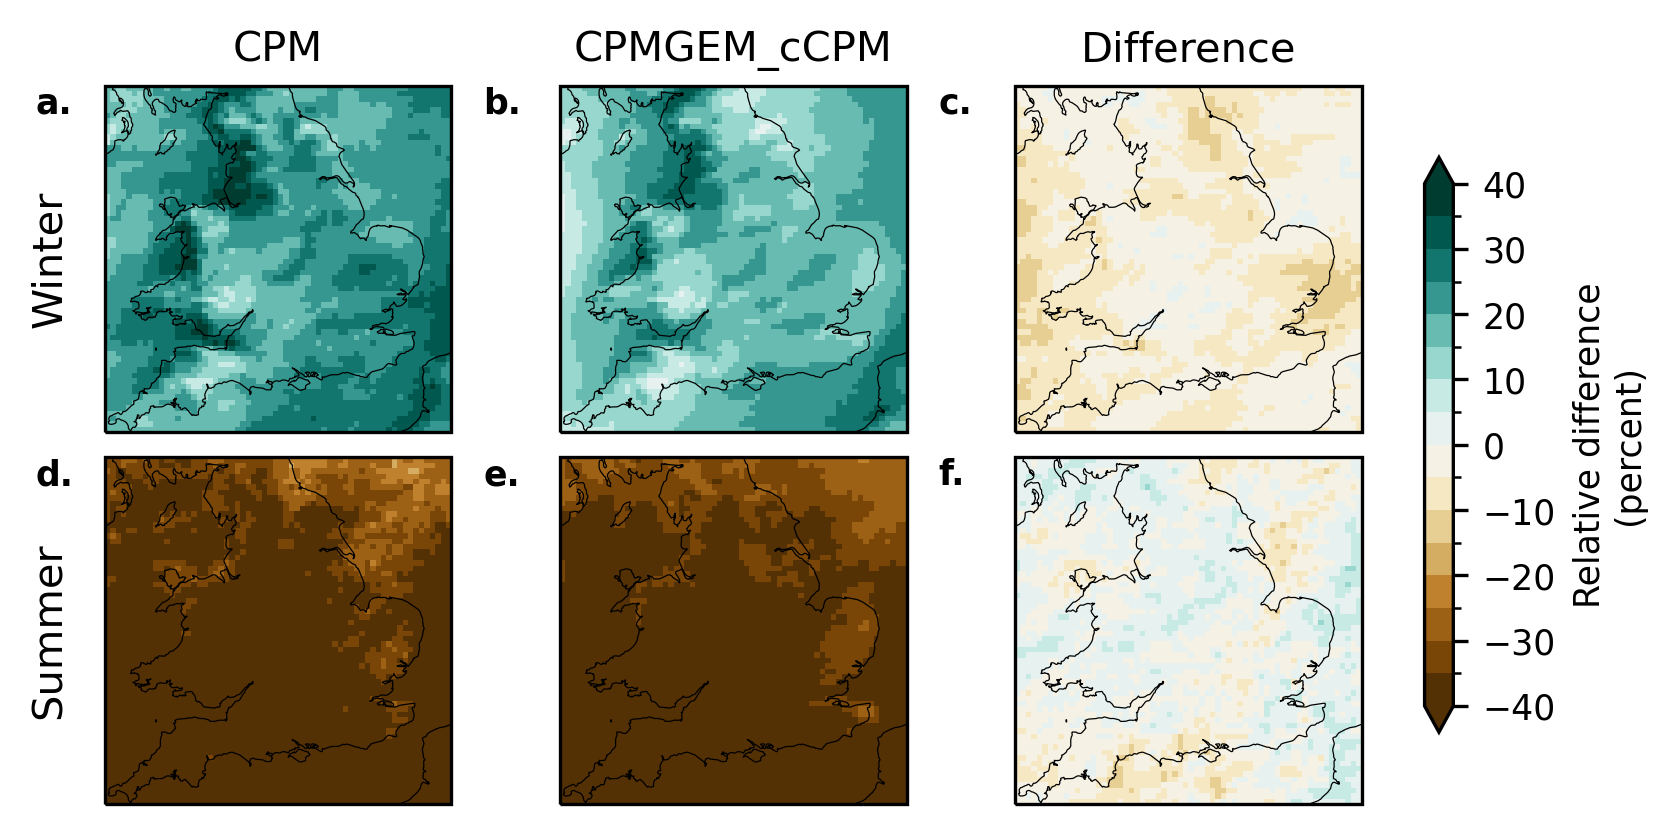

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"#### {var}", raw=True)    
    for model, ccs_pred_da in CCS_PRED_DAS[var].groupby("model"):
        changes = compute_changes([ccs_pred_da.squeeze("model")], CPM_DAS[var], CCS_SEASONS, stat_func=xr.DataArray.mean)
        change_fig = plt.figure(figsize=(5.5, 4.5), layout="compressed")
        plot_changes(changes, CCS_SEASONS, change_fig, show_change=[model])
        
    plt.show()

### CCS mean Variablity

## Change in extremes

### High quantile change maps

#### pr 0.99

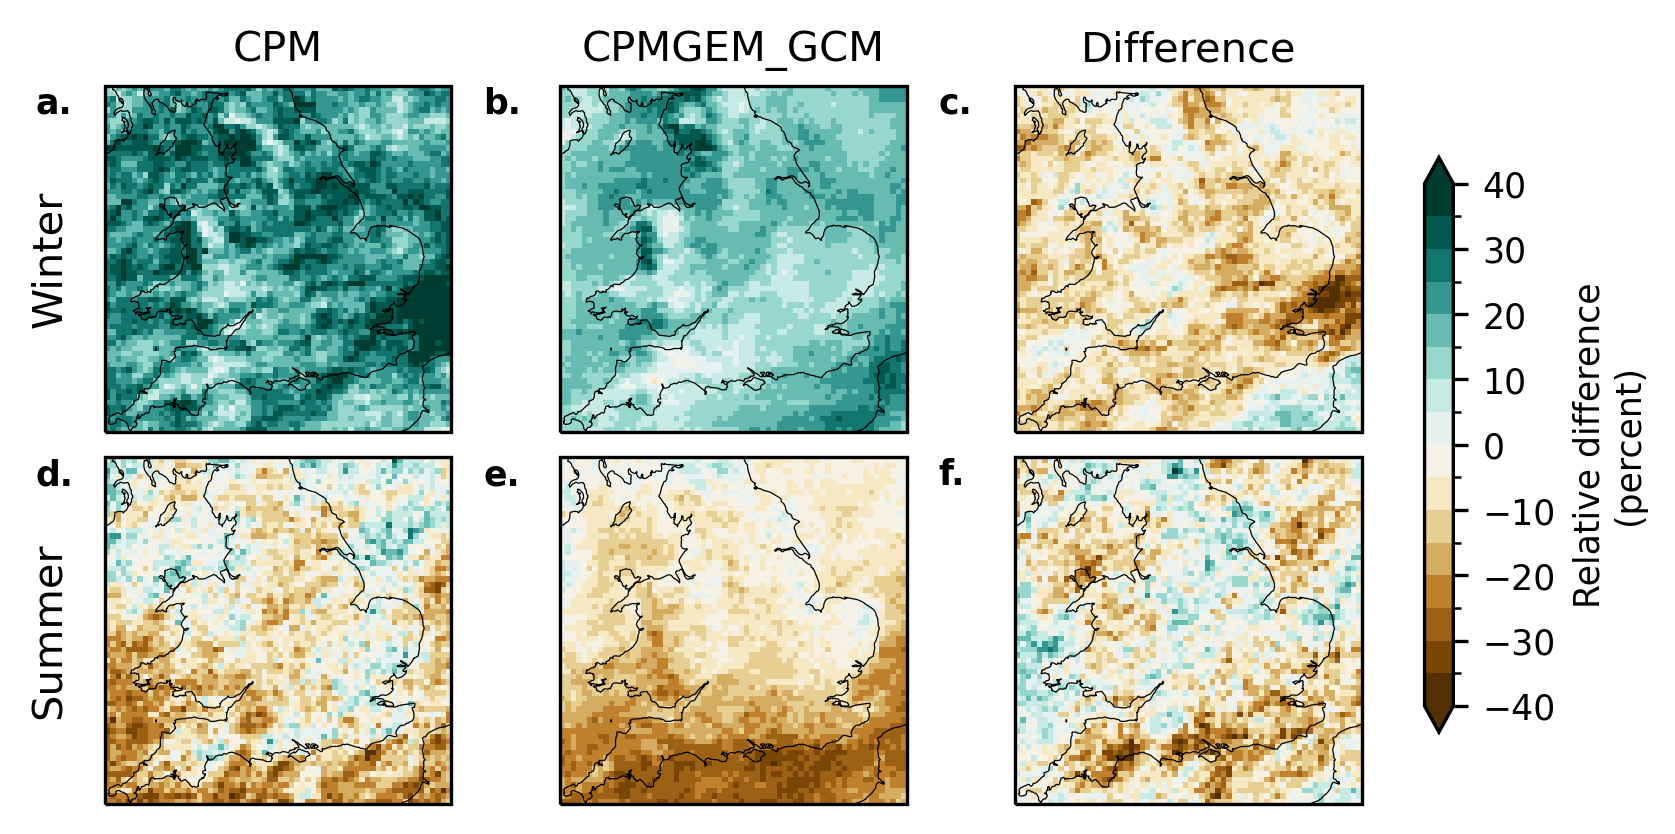

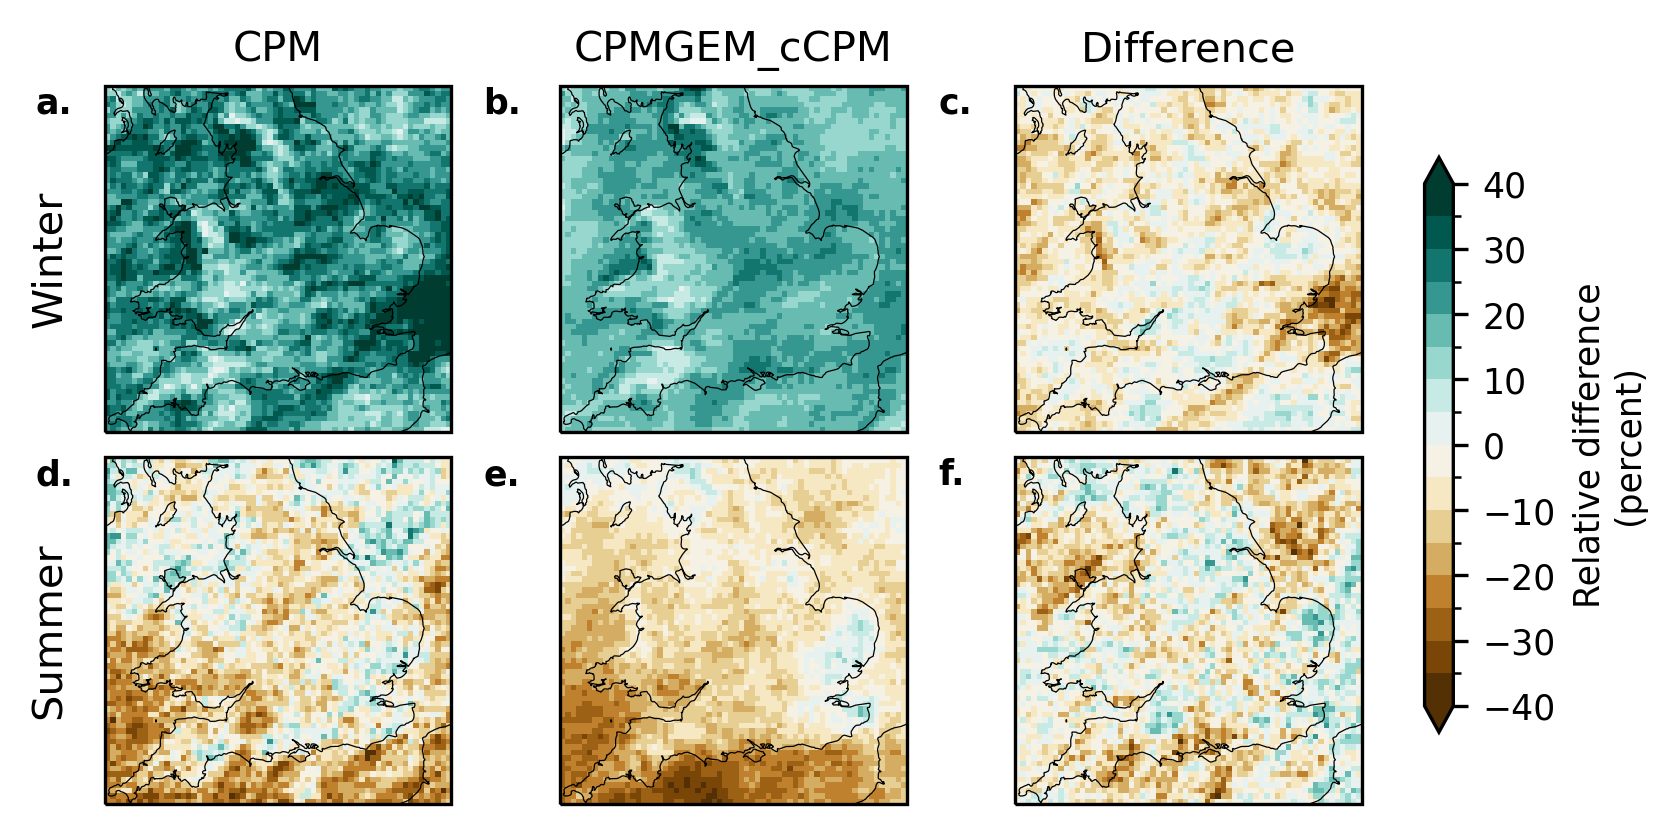

#### pr 0.999

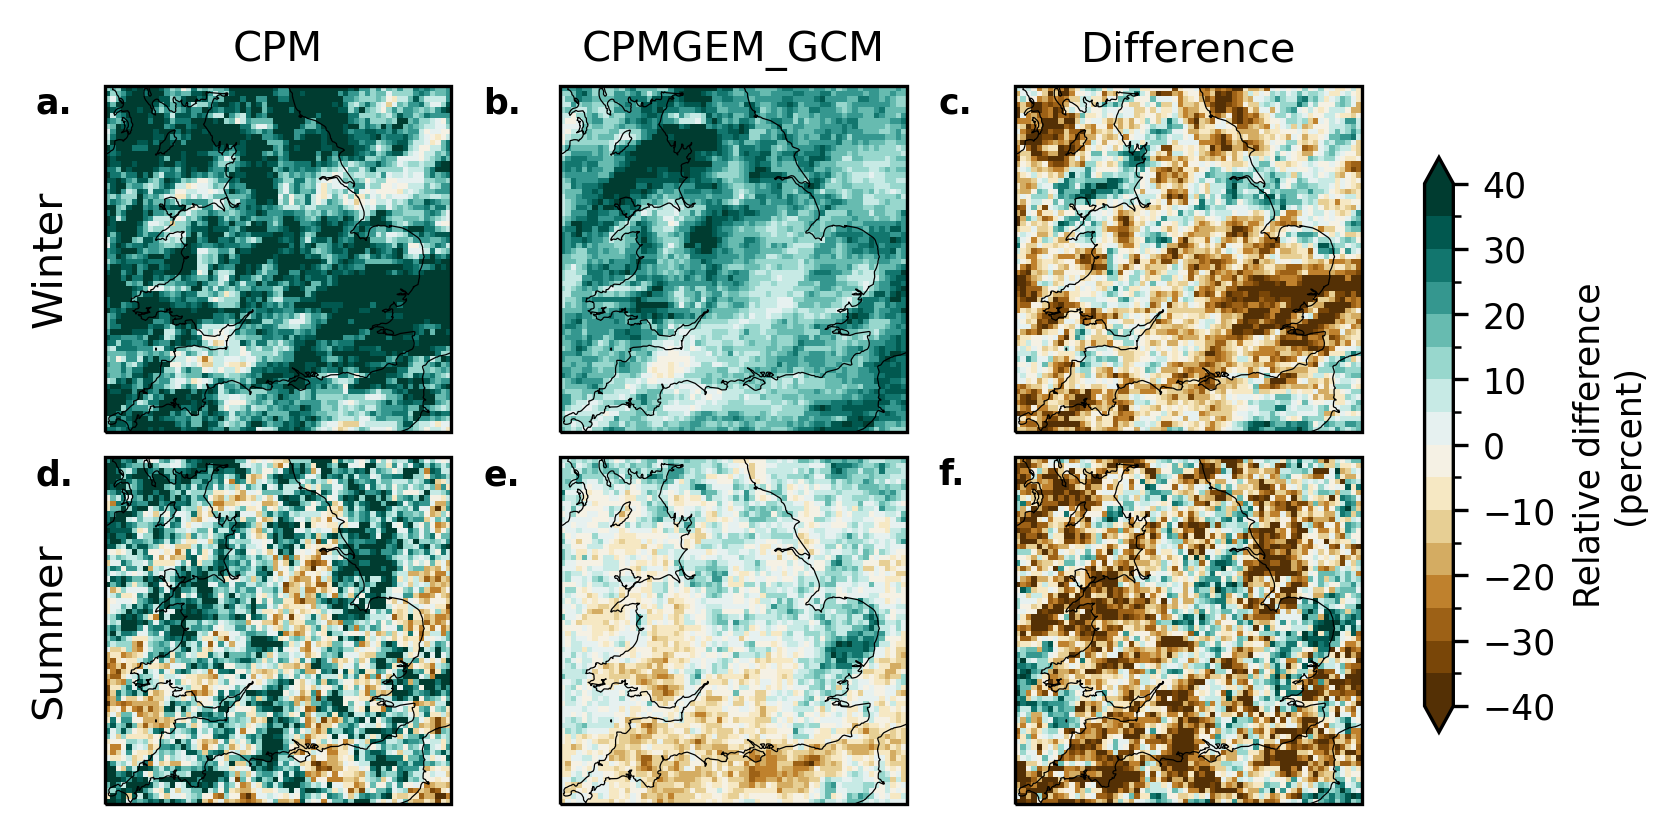

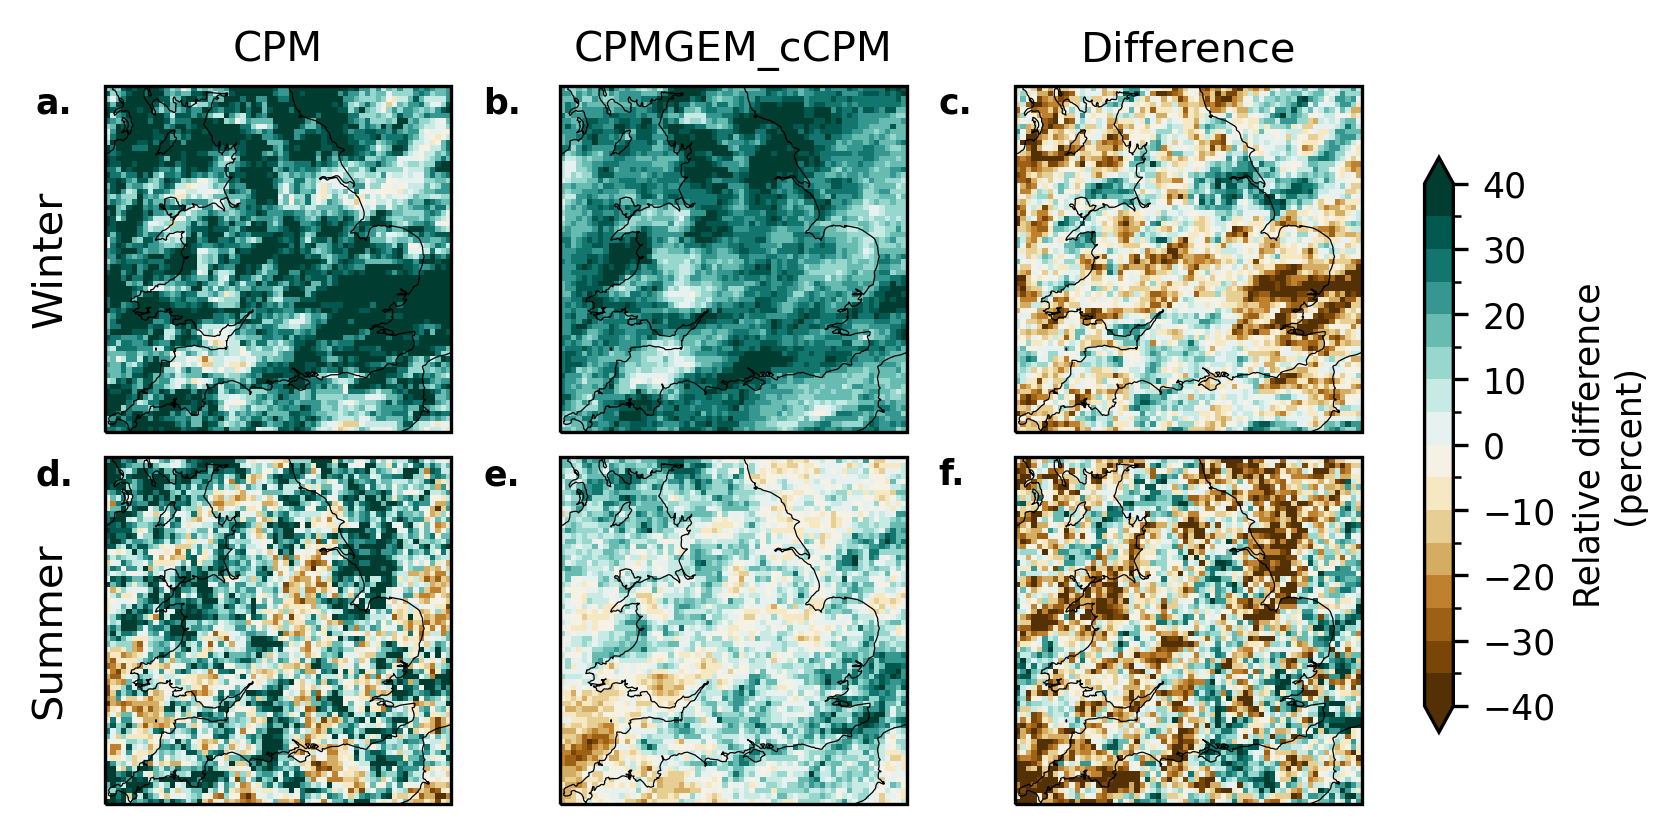

In [ ]:
for var in eval_vars:
    for q in PER_GRIDBOX_QUANTILES:
        IPython.display.display_markdown(f"#### {var} {q}", raw=True)
        for model, ccs_pred_da in CCS_PRED_DAS[var].groupby("model"):
            changes = compute_changes([ccs_pred_da.squeeze("model")], CPM_DAS[var], CCS_SEASONS, stat_func=functools.partial(xr.DataArray.quantile, q=q))
            change_fig = plt.figure(figsize=(5.5, 4.5), layout="compressed")
            plot_changes(changes, CCS_SEASONS, change_fig, show_change=[model])
            
        plt.show()

### Between samples

i.e. for emulator compute quantiles separately for all sets of samples

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)
    
    quantiles_ds = xr.merge([
        chained_groupby_map(
            CCS_DS[f"pred_{var}"], 
            ["model", "time.season", "time_period"], 
            lambda gda: gda.quantile(q=PER_GRIDBOX_QUANTILES, dim=["ensemble_member", "time"])
        ).rename(f"pred_{var}_q"),
        chained_groupby_map(
            CCS_DS[f"target_{var}"], 
            ["time.season", "time_period"],
            lambda gda: gda.quantile(q=PER_GRIDBOX_QUANTILES, dim=["ensemble_member", "time"])
        ).rename(f"target_{var}_q")],

    )
    
    quantiles_change_ds = (quantiles_ds.sel(time_period="future") - quantiles_ds.sel(time_period="historic"))

    quantiles_rel_change_ds = 100*(quantiles_change_ds / quantiles_ds.sel(time_period="historic").drop("time_period"))

    mean_q_rel_change_ds = quantiles_rel_change_ds.mean(dim=["grid_longitude", "grid_latitude"])
    
    pretty_table(
        xr.merge([
            xr.concat([
                mean_q_rel_change_ds[f"pred_{var}_q"].mean(dim=["sample_id"]),
                mean_q_rel_change_ds[f"target_{var}_q"].expand_dims(model=["CPM"]),
            ], dim="model").rename("Mean relative change [%]"),
            mean_q_rel_change_ds[f"pred_{var}_q"].min(dim=["sample_id"]).rename("Min mean rel. change over sample_id [%]"),
            mean_q_rel_change_ds[f"pred_{var}_q"].max(dim=["sample_id"]).rename("Max mean rel. change over sample_id [%]"),
            mean_q_rel_change_ds[f"pred_{var}_q"].std(dim=["sample_id"]).rename("Std mean rel. change over sample_id [%]"),

        # xr.merge([quantiles_da.sel(time_period="historic", model="CPM").rename("historic CPM"), quantiles_change_da, quantiles_rel_change_da]),
        ]),
        round=1, 
        caption="Seasonal quantile change",
        dim_order=["season", "quantile", "model"],
    )

### pr

Seasonal quantile change 
 
 
   
   
   
 Mean relative change [%] 
 Min mean rel. change over sample_id [%] 
 Max mean rel. change over sample_id [%] 
 Std mean rel. change over sample_id [%] 
 
 
 season 
 quantile 
 model 
   
   
   
   
 
 
 
 
 DJF 
 0.990000 
 CPM 
 23.8 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 15.7 
 12.4 
 17.8 
 1.8 
 
 
 CPMGEM_cCPM 
 18.7 
 15.3 
 24.6 
 3.0 
 
 
 0.999000 
 CPM 
 28.3 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 20.1 
 16.8 
 24.1 
 2.7 
 
 
 CPMGEM_cCPM 
 25.0 
 23.1 
 31.0 
 2.8 
 
 
 JJA 
 0.990000 
 CPM 
 -7.0 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 -11.9 
 -14.2 
 -9.2 
 1.7 
 
 
 CPMGEM_cCPM 
 -10.9 
 -12.3 
 -9.5 
 1.0 
 
 
 0.999000 
 CPM 
 12.5 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 1.5 
 -1.0 
 5.6 
 2.2 
 
 
 CPMGEM_cCPM 
 7.0 
 5.4 
 8.2 
 1.1 
 
 
 MAM 
 0.990000 
 CPM 
 11.7 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 8.0 
 4.6 
 10.7 
 1.8 
 
 
 CPMGEM_cCPM 
 9.9 
 9.3 
 11.3 
 0.8 
 
 
 0.999000 
 CPM 
 13.2 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 7.1 
 -0.0 
 10.9 
 3.5 
 
 
 CPMGEM_cCPM 
 11.8 
 8.8 
 14.3 
 1.7 
 
 
 SON 
 0.990000 
 CPM 
 12.5 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 8.0 
 6.4 
 10.8 
 1.4 
 
 
 CPMGEM_cCPM 
 11.3 
 8.1 
 15.8 
 2.6 
 
 
 0.999000 
 CPM 
 16.2 
 nan 
 nan 
 nan 
 
 
 CPMGEM_GCM 
 11.5 
 9.6 
 14.9 
 1.7 
 
 
 CPMGEM_cCPM 
 15.6 
 11.8 
 19.7 
 2.9

### Across samples

i.e. compute quantiles using all samples lumped together for diffusion models

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)
    
    quantiles_da = xr.concat([
        chained_groupby_map(
            CCS_DS[f"pred_{var}"], 
            ["model", "time.season", "time_period"], 
            lambda gda: gda.quantile(q=PER_GRIDBOX_QUANTILES, dim=["ensemble_member", "time", "sample_id"])
        ),
        chained_groupby_map(
            CCS_DS[f"target_{var}"], 
            ["time.season", "time_period"],
            lambda gda: gda.quantile(q=PER_GRIDBOX_QUANTILES, dim=["ensemble_member", "time"])
        ).expand_dims(model=["CPM"])],
        dim="model",
    ).rename("quantile value")
    
    quantiles_change_da = (quantiles_da.sel(time_period="future") - quantiles_da.sel(time_period="historic")).rename("Change [mm/day]")

    quantiles_rel_change_da = 100*(quantiles_change_da / quantiles_da.sel(time_period="historic").drop("time_period")).rename("Relative Change [%]")
    pretty_table(
        xr.merge([
            quantiles_change_da.mean(dim=["grid_longitude", "grid_latitude"]).rename("mean change [mm/day]"),
            quantiles_rel_change_da.mean(dim=["grid_longitude", "grid_latitude"]).rename("mean relative change [%]"),
            quantiles_rel_change_da.std(dim=["grid_longitude", "grid_latitude"]).rename("std relative change [%]"),
        ]),
        # xr.merge([quantiles_da.sel(time_period="historic", model="CPM").rename("historic CPM"), quantiles_change_da, quantiles_rel_change_da]),
        round=1, 
        caption="Seasonal quantile change bootstrapped spread",
        dim_order=["season", "quantile", "model"],
    )

### pr

Seasonal quantile change bootstrapped spread 
 
 
   
   
   
 mean change [mm/day] 
 mean relative change [%] 
 std relative change [%] 
 
 
 season 
 quantile 
 model 
   
   
   
 
 
 
 
 DJF 
 0.990000 
 CPMGEM_cCPM 
 4.2 
 18.6 
 4.3 
 
 
 CPMGEM_GCM 
 3.5 
 15.6 
 5.8 
 
 
 CPM 
 5.3 
 23.8 
 8.2 
 
 
 0.999000 
 CPMGEM_cCPM 
 8.9 
 24.6 
 9.0 
 
 
 CPMGEM_GCM 
 7.2 
 19.7 
 9.3 
 
 
 CPM 
 9.9 
 28.3 
 16.4 
 
 
 JJA 
 0.990000 
 CPMGEM_cCPM 
 -2.4 
 -11.0 
 8.5 
 
 
 CPMGEM_GCM 
 -2.5 
 -12.0 
 9.4 
 
 
 CPM 
 -1.6 
 -7.0 
 10.9 
 
 
 0.999000 
 CPMGEM_cCPM 
 2.3 
 6.3 
 11.4 
 
 
 CPMGEM_GCM 
 0.1 
 0.8 
 10.2 
 
 
 CPM 
 4.5 
 12.5 
 21.1 
 
 
 MAM 
 0.990000 
 CPMGEM_cCPM 
 2.0 
 9.8 
 6.0 
 
 
 CPMGEM_GCM 
 1.6 
 7.8 
 6.8 
 
 
 CPM 
 2.3 
 11.7 
 9.0 
 
 
 0.999000 
 CPMGEM_cCPM 
 3.9 
 11.1 
 9.8 
 
 
 CPMGEM_GCM 
 2.3 
 6.3 
 10.2 
 
 
 CPM 
 4.1 
 13.2 
 16.2 
 
 
 SON 
 0.990000 
 CPMGEM_cCPM 
 2.6 
 11.1 
 6.2 
 
 
 CPMGEM_GCM 
 1.9 
 7.9 
 6.0 
 
 
 CPM 
 2.9 
 12.5 
 9.0 
 
 
 0.999000 
 CPMGEM_cCPM 
 5.9 
 14.7 
 9.8 
 
 
 CPMGEM_GCM 
 4.3 
 10.7 
 10.8 
 
 
 CPM 
 6.5 
 16.2 
 17.5

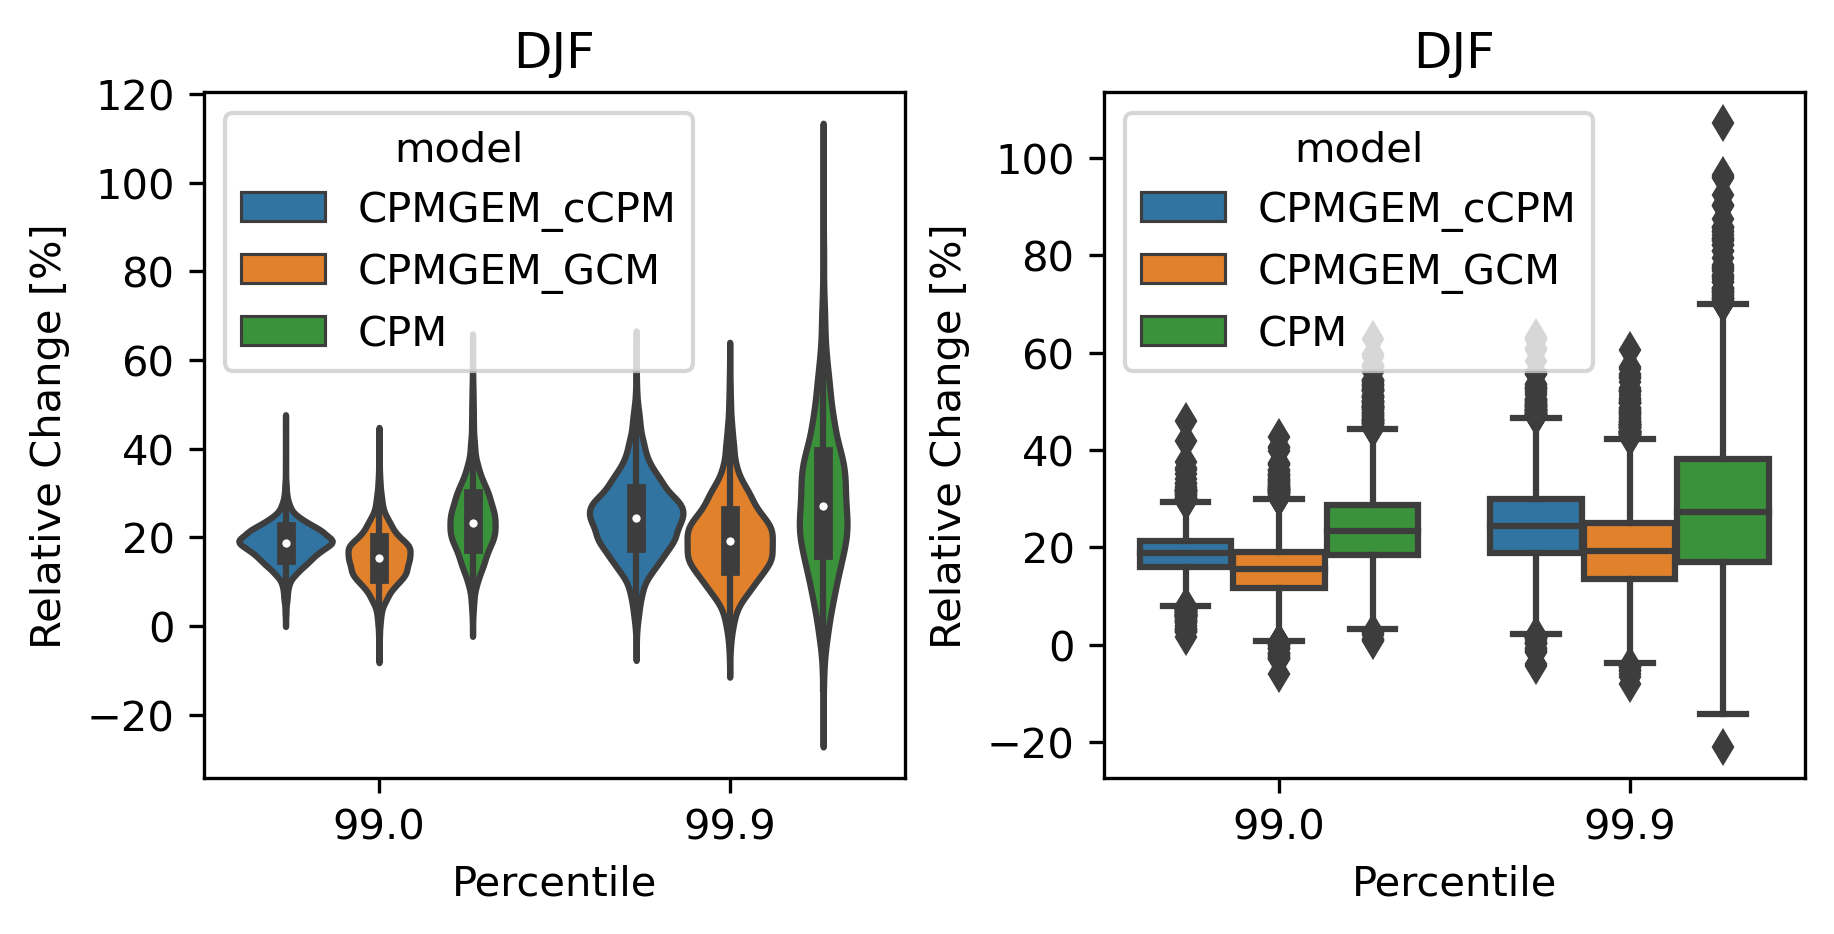

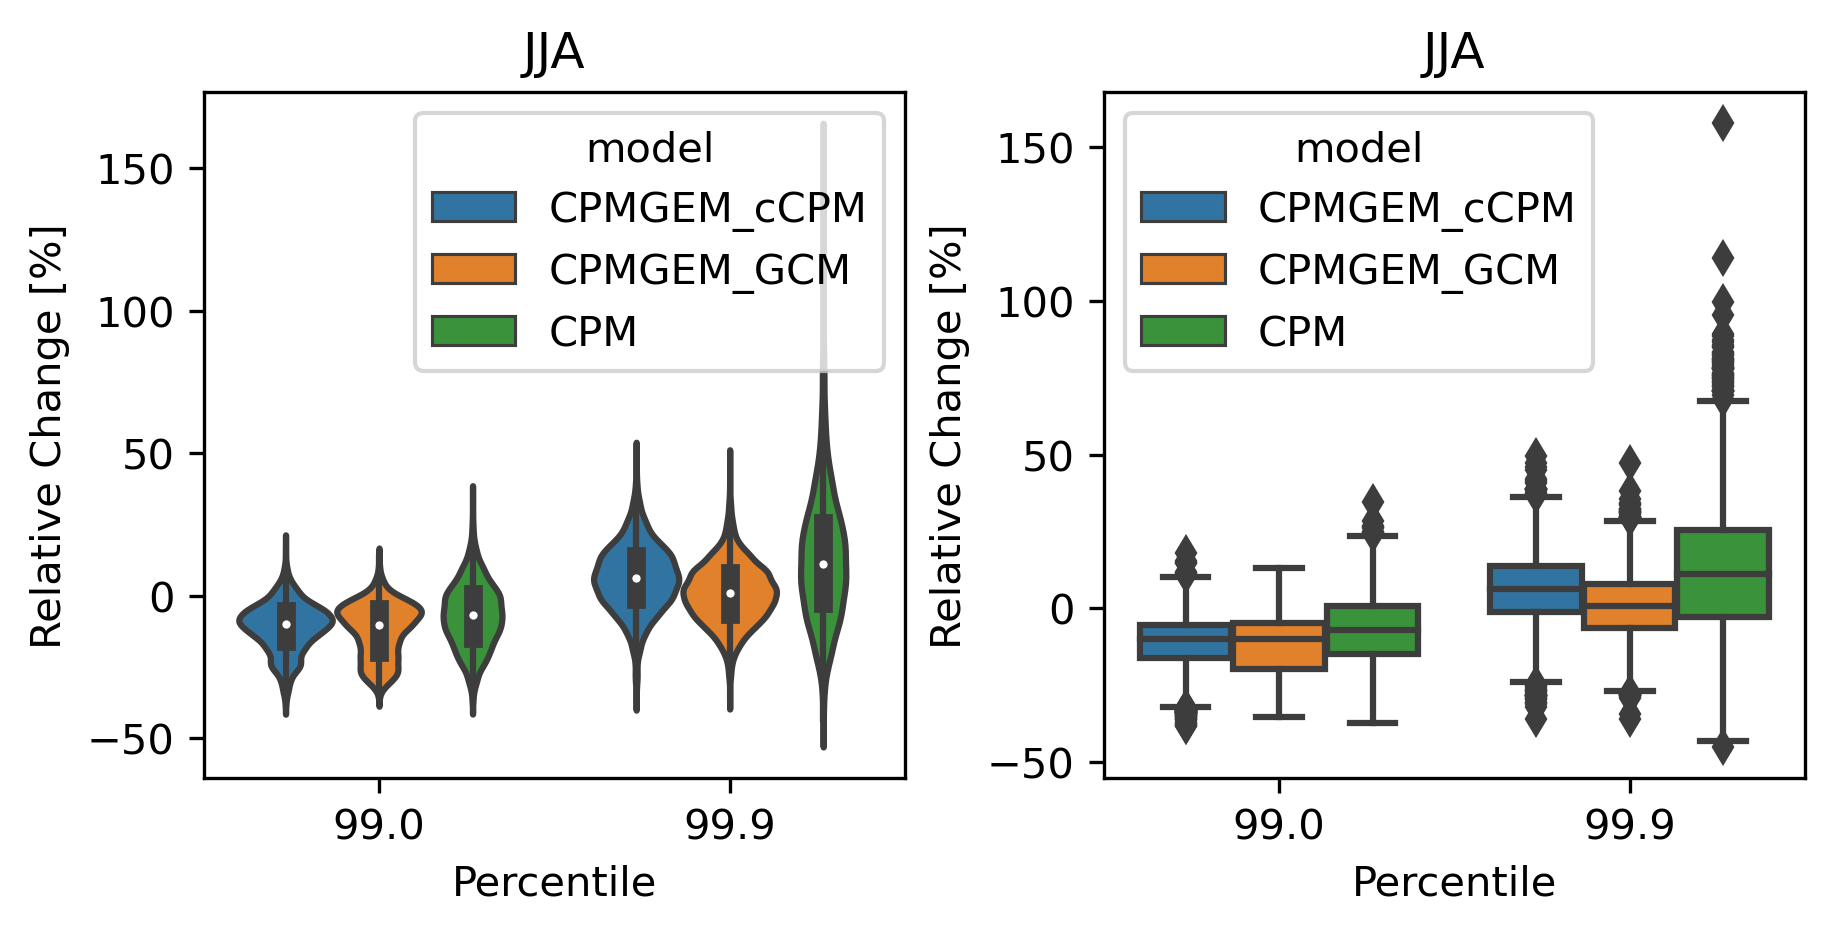

In [ ]:
for season, season_q_change_da in quantiles_rel_change_da.groupby("season"):
    if season not in CCS_SEASONS:
        continue
    fig, axs = plt.subplots(1, 2, layout="compressed", figsize=(6,3))
    data = season_q_change_da.to_dataframe().reset_index()
    data["Percentile"] = (data["quantile"]*100).astype('category')
    sns.violinplot(data, y="Relative Change [%]", x="Percentile", hue="model", orientation="v", ax=axs[0]).set_title(season)
    sns.boxplot(data, y="Relative Change [%]", x="Percentile", hue="model", ax=axs[1]).set_title(season)
    plt.show()

## Figure: per subdomain per time period per season distribution

### pr

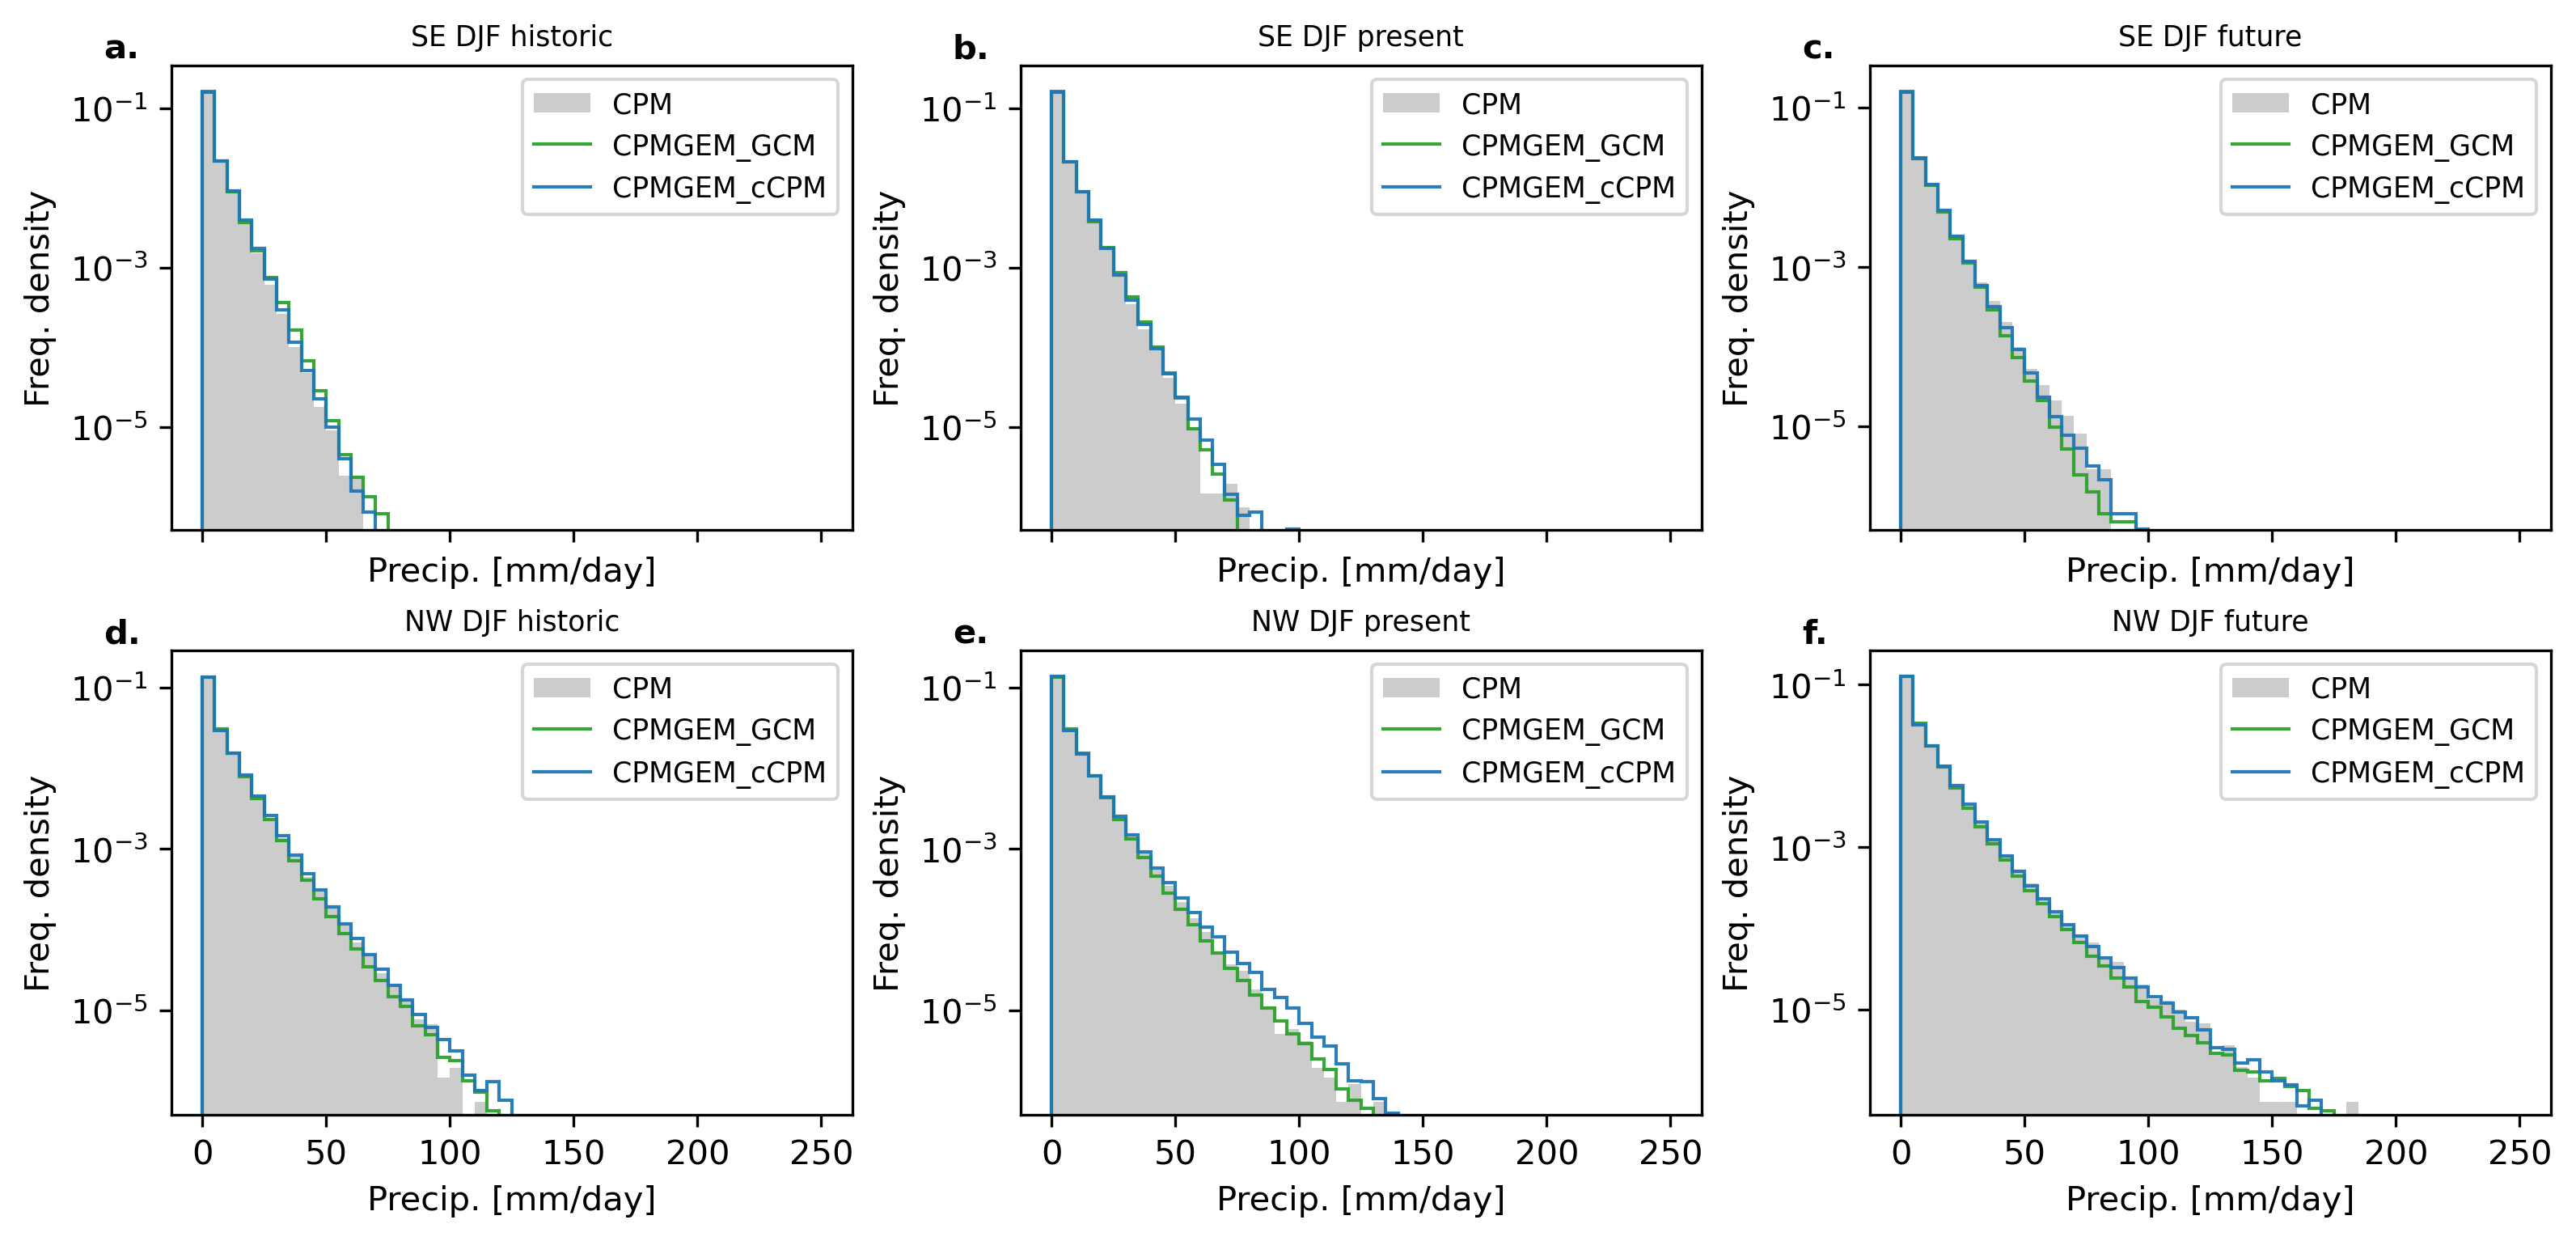

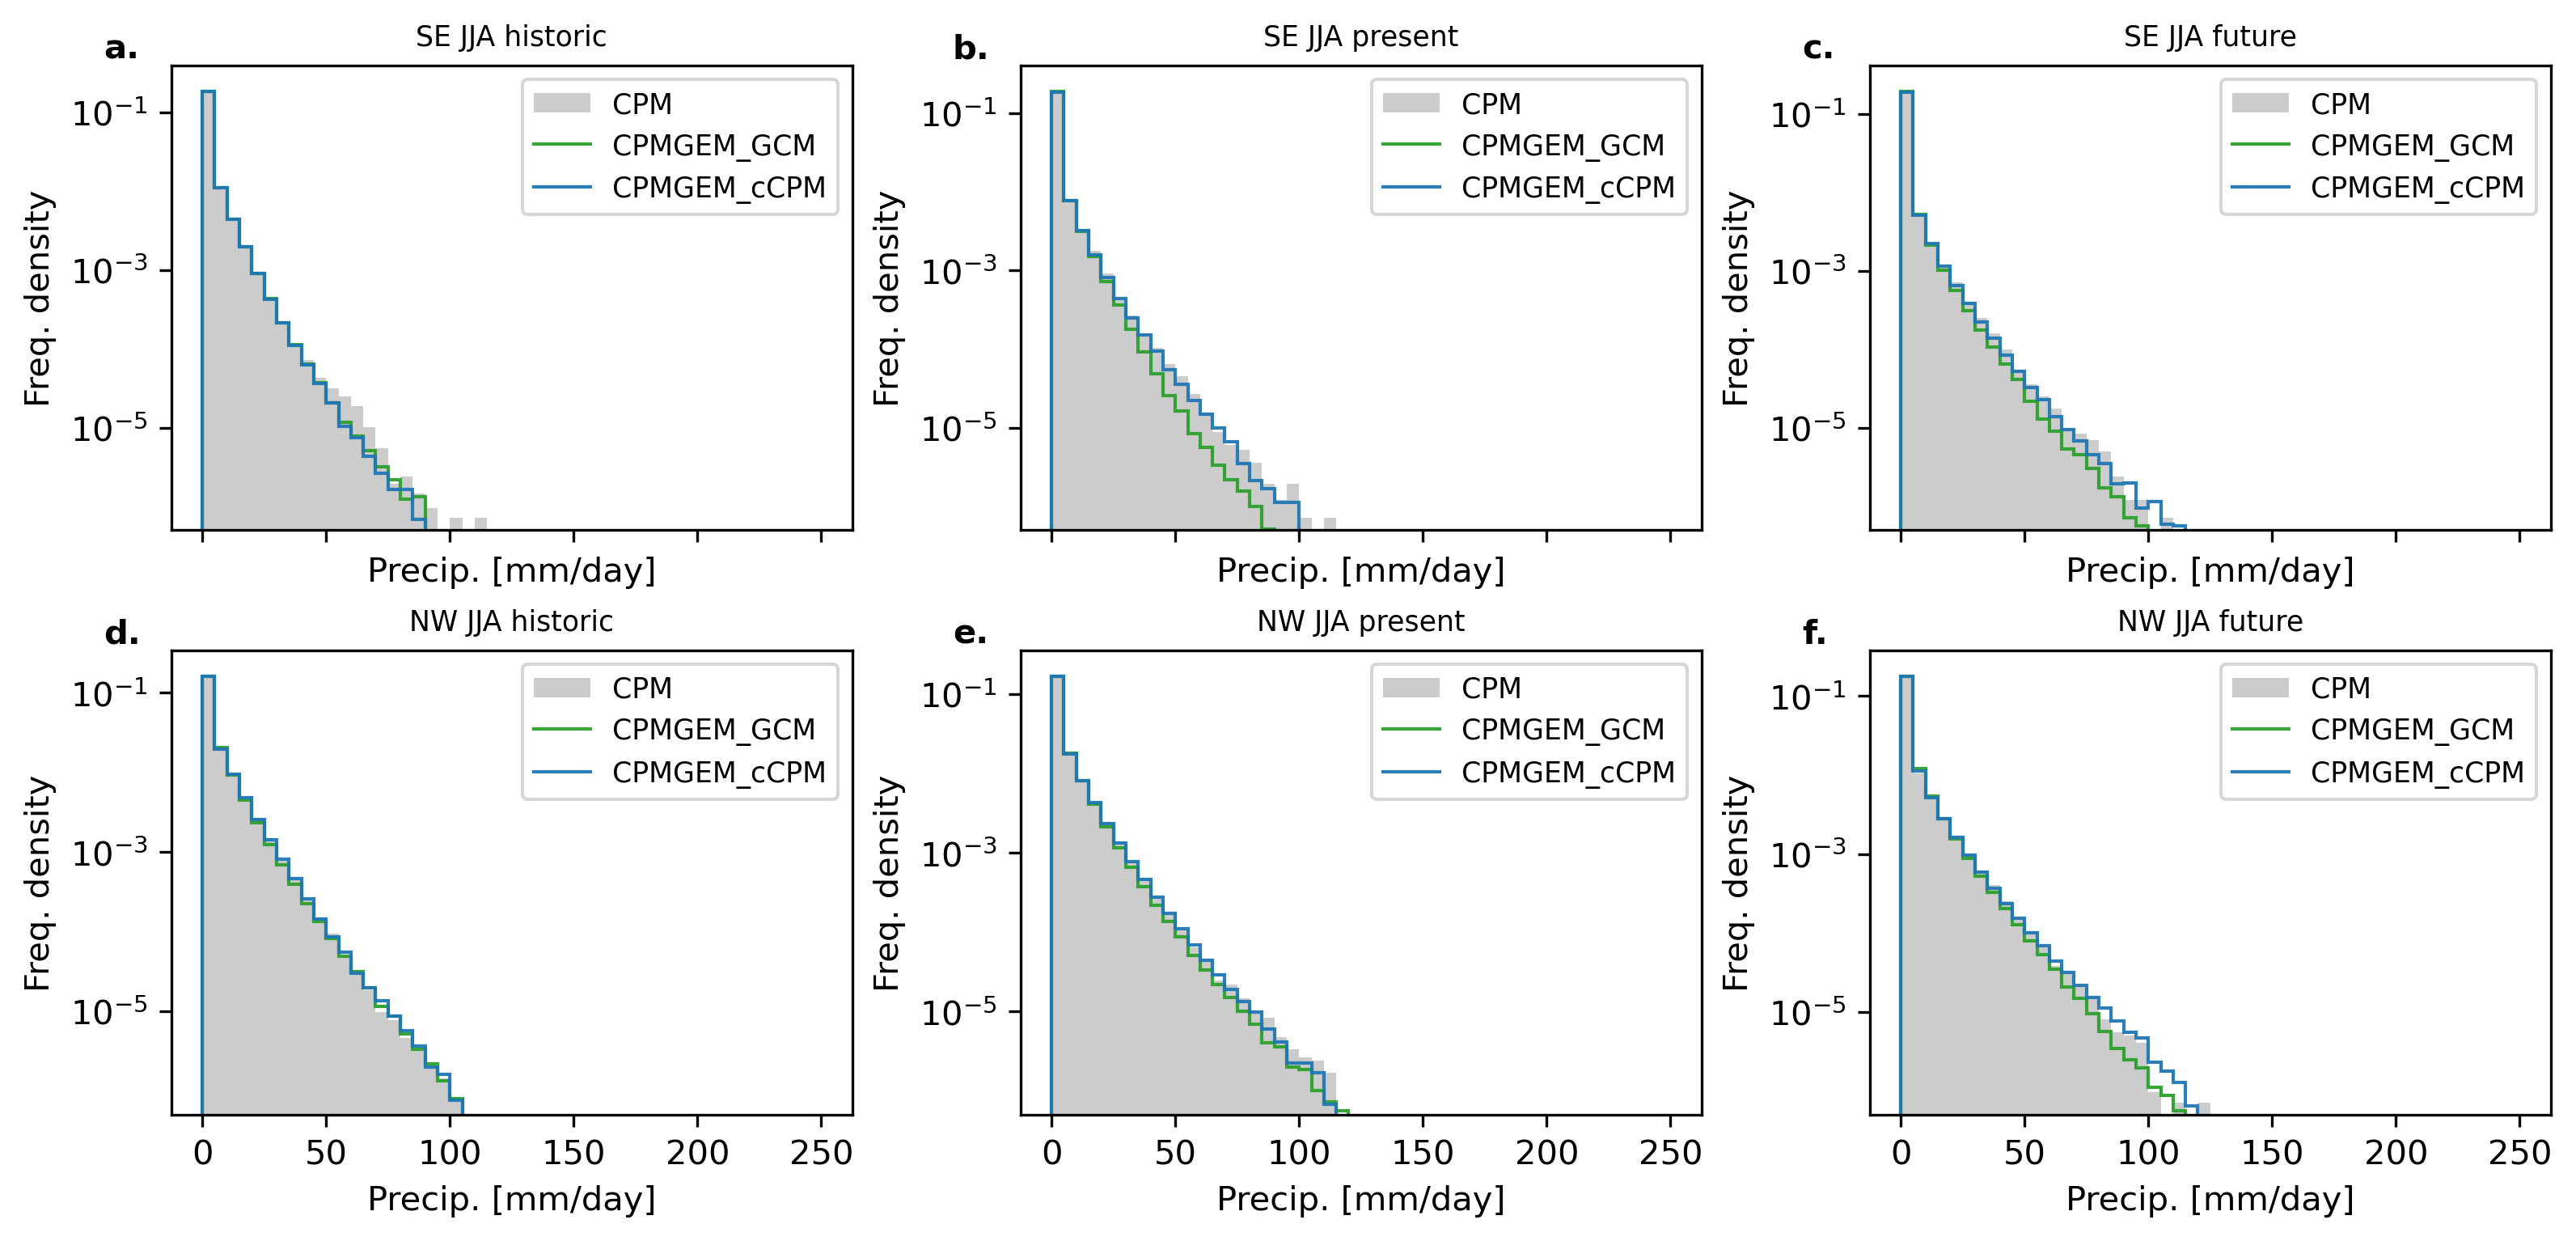

In [ ]:
from collections import deque
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)

    for season, seasonal_ccs_ds in CCS_DS.groupby("time.season"):
        if season not in CCS_SEASONS:
            continue

        fig = plt.figure(figsize=(3.5*len(TIME_PERIODS), 2.5*len(SUBREGIONS)), layout="compressed")

        spec = np.array(list([[f"{srname} {tp_key}" for tp_key in TIME_PERIODS.keys()] for srname in SUBREGIONS.keys()]))
        axd = fig.subplot_mosaic(spec, sharex=True)#, sharey=True)
        panel_label_iter = iter(string.ascii_lowercase)
        for srname, srdefn in SUBREGIONS.items():
            for tp_key, tp_ds in seasonal_ccs_ds.groupby("time_period"):
            
                tpsrseason_cpm_da = tp_ds[f"target_{var}"].isel(**SUBREGIONS[srname])
                
                srseason_hist_data = [
                    dict(data=model_ds[f"pred_{var}"].isel(**SUBREGIONS[srname]), label=model, color=MODELLABEL2SPEC[model]["color"]) for model, model_ds in tp_ds.groupby("model")
                ]
    
                ax = axd[f"{srname} {tp_key}"]
                if var == "pr":
                    kwargs = {
                        "yscale": "log",
                    }
                else:
                    kwargs = {
                        "yscale": "linear",
                    }
                plot_freq_density(srseason_hist_data, ax=ax, target_da=tpsrseason_cpm_da, linewidth=1, hrange=VAR_RANGES[var], **kwargs)
                ax.set_title(f"{srname} {season} {tp_key}", size="small")

        deque(axd[axlabel.item()].annotate(f"{next(panel_label_iter)}.", xy=(-0.1, 1.0), xycoords=("axes fraction", "axes fraction"), weight='bold', ha="left", va="bottom") for axlabel in np.nditer(spec))
    
        plt.show()